In [1]:
import glob
import csv
import pandas as pd
import numpy as np
from os import listdir
import matplotlib.pyplot as plt
from itertools import combinations

## Data Wrangling
1. Load each individual CSV file data into a dataframe.
2. Add each dataframe to a dictionary of dataframes.
3. Inspect the data.

Data Wrangling Functions 

In [2]:
def inspect_di_df(this_di):
    for df in this_di.keys():
        print('\nDataframe: {}\n'.format(df))
        print(this_di[df].info(verbose=False))
        print('='*50)
        
        
def print_df_preview(dfname, df):
    """Print the first & last several rows & columns of a dataframe."""
    print('\n{}\n{} {} :\n\n{}' \
          .format("="*50, dfname, \
                df.shape, \
                df[list(df.columns[0:3]) + list(df.columns[-3:])].iloc[[0,1,-2,-1]] \
               )) 
    
    
def print_dfdict_preview(df_dict):
    """Print preview of dataframes within a dictionary."""
    print('\nHead & Tail of DataFrame rows & columns:\n')
    [print_df_preview(dfname, df) for dfname, df in df_dict.items()]
    

### 1. Load CSV file data into dictionary of dataframes.

TODO: do not hardcode 'Data' directory

In [3]:
datasets_di = {}  # dictionary of dataframes of loaded data

# Load .csv files
for fullname in glob.glob('Data/*.csv'):
    # extract filename w/o path or extension
    filename = fullname.rsplit('.csv')[0].split('/')[-1]
    datasets_di[filename] = pd.read_csv(fullname)


First, find the CSV files. For now, they are in an hardcoded list of directories.

Create dictionary of dataframes.

### 3. Inspect the data.

In [4]:
inspect_di_df(datasets_di)


Dataframe: life_expectancy_years

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187 entries, 0 to 186
Columns: 220 entries, geo to 2018
dtypes: float64(219), object(1)
memory usage: 321.5+ KB
None

Dataframe: hdi_human_development_index

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187 entries, 0 to 186
Columns: 27 entries, geo to 2015
dtypes: float64(26), object(1)
memory usage: 39.5+ KB
None


#### Observations:
* Column 1 (country) are inconsistently named ('geo' and 'country')
* Year columns have inconsistent datatypes (float64 and int64)

Preview a few rows & columns of each dataframe (there are likely 'too many' columns to view easily).

In [5]:
print_dfdict_preview(datasets_di)


Head & Tail of DataFrame rows & columns:


life_expectancy_years (187, 220) :

             geo  1800  1801  2016  2017  2018
0    Afghanistan  28.2  28.2  58.0  58.4  58.7
1        Albania  35.4  35.4  77.7  77.9  78.0
185       Zambia  32.6  32.6  58.8  59.1  59.5
186     Zimbabwe  33.7  33.7  59.3  59.8  60.2

hdi_human_development_index (187, 27) :

             geo   1990   1991   2013   2014   2015
0    Afghanistan  0.295  0.300  0.476  0.479  0.479
1        Albania  0.635  0.618  0.761  0.762  0.764
185       Zambia  0.398  0.396  0.570  0.576  0.579
186     Zimbabwe  0.499  0.501  0.498  0.507  0.516


#### Observations:
* There are a variety of year ranges between df's
* There are a variety of country sets between df's
* Some values are Null (NaN)
* Some values are zero (0)

---
## Data Cleaning
Clean the datasets to make it ready for analysis.

First, create metadata `meta_df` to itemize our data sets and track changes to them. Then:

### Clean

1. Simplify dataframe names
2. Rename and index columns
1. Standardize datatypes (within each dataframe)

### Trim

 
 **Zeros and NaN**
 
 Zero values are assumed to be years in which a statistic for a <br>
 country was not gathered. Zeros can skew the data when calculating <br>
 aggregates. For this reason, reset zero values to NaN.
 
 **Countries**
 
 Not all dataframes contain the same set of countries.  Avoid <br>
attempting to draw correlation between country statistics when not all <br>
countries have recorded statistics by trimming dataframes so they share <br>
a common set of countries.

 **Years**: Not all dataframes contain the same range of years. <br>
 Trim dataframes so they share a common range of years for consistent <br>
 analysis.

In [6]:
# Create backup
datasets_di_backup = datasets_di

### Create Metadata of data sets

In [7]:
meta_df = pd.DataFrame([dfname for dfname in datasets_di.keys()], \
                       columns=['dataframe'])
meta_df

,dataframe
0,life_expectancy_years
1,hdi_human_development_index


### Clean 1: simplify dataframe names
Dataframes were named with CSV filenames, which are long and wordy. <br>
Create shorter aliases in `meta_df`.  

First, create an alias dictionary. Prompt user for each alias, offer a default ...

In [8]:
alias_di = {}

For each df, prompt for alias, default = first word delimited by underscore
(For now, just accept default. TODO find some other solution to too-long df names)

In [9]:
print('\nEnter alias for each dataframe (press enter to accept default):\n')
for dfname in datasets_di.keys():
    this_alias = '_'.join(dfname.split('_', 2)[:2])
    #this_alias = input('{}: ({})'.format(dfname, this_alias)) or this_alias
    alias_di[dfname] = this_alias
    #print('"'+'\n"'.join(str(dfname)+'":"'+str(dfname).split("_")[0]+'",'))


Enter alias for each dataframe (press enter to accept default):



In [10]:
print(alias_di)

{'life_expectancy_years': 'life_expectancy', 'hdi_human_development_index': 'hdi_human'}


Map the dataframe aliases to `meta_df` dataframe names and index on it.

In [11]:
meta_df['statistic'] = meta_df['dataframe'].map(alias_di)
meta_df.set_index('statistic', inplace=True)
meta_df

,dataframe
statistic,
life_expectancy,life_expectancy_years
hdi_human,hdi_human_development_index


Now rename dataframes using the aliases ...

create list original dataframe names

In [12]:
dflist = list(datasets_di.keys())

rename dataframes with their statistic name (mapped in meta_df)

In [13]:
for df in dflist:
    datasets_di[meta_df[meta_df['dataframe'] == df].index[0]] = datasets_di.pop(df)

Verify new dataframe (statistic) names

In [14]:
list(datasets_di.keys())

['life_expectancy', 'hdi_human']

### Clean 2: Rename and index columns

Dataframes contain a column for country name, followed by a sequence of year columns. 

Standardize the name of the country column to 'country' then index on it.

In [15]:
# function to rename/reindex
f = lambda df: (df.rename(columns={'geo':'country'}).set_index('country'))

for dfname in list(datasets_di.keys()):
    datasets_di[dfname] = f(datasets_di[dfname])

Confirm all indexes are 'country' <br>
TODO: add error handling procedures

In [16]:
print('Are all dataframe indexes named "country"?')
'country' == np.unique(list(map(lambda k: datasets_di[k].index.name,(k for k in datasets_di.keys()))))[0]

Are all dataframe indexes named "country"?


True

### Clean 3: Standardize datatypes

First discover what each dataframe's datatypes should be: float or integer. For example, the number of murders or earthquakes in a year will be integers, while percentage values will be floats. Rely on the panda data loaders which attempted to discover the data types. Default to integer unless any floats were detected.

In [17]:
for k in datasets_di.keys():
    # TODO find a sexier way to code this:
    # If there are both floats and integers, change integers to floats.
    float_count = len(datasets_di[k].select_dtypes(include=[np.float]).count())
    integer_count = len(datasets_di[k].select_dtypes(include=[np.integer]).count())
    if (integer_count > 0 and float_count > 0):
        datasets_di[k] = datasets_di[k].astype(float)

In [18]:
inspect_di_df(datasets_di)


Dataframe: life_expectancy

<class 'pandas.core.frame.DataFrame'>
Index: 187 entries, Afghanistan to Zimbabwe
Columns: 219 entries, 1800 to 2018
dtypes: float64(219)
memory usage: 321.4+ KB
None

Dataframe: hdi_human

<class 'pandas.core.frame.DataFrame'>
Index: 187 entries, Afghanistan to Zimbabwe
Columns: 26 entries, 1990 to 2015
dtypes: float64(26)
memory usage: 39.4+ KB
None


### Trim
Backup datasets_di before trimming

In [19]:
datasets_di_backup = datasets_di.copy()

#### Zeros and NaN - Cleanup<br>
> TODO: Rethink logic below. Some datasets include events counts 
that may not happen every year, such as environmental disasters. 
Therefore, zero means zero, not 'unknown' or missing data.

Any Zero values are assumed to be placeholders for missing data. <br>
Since zero values can inadvertently skew aggregate calculations, <br>
reset them to NaN (null).<br>
<br>
Afterwards, make sure there are now no rows completely empty.

Functions for Cleanup

In [20]:
def print_zeros(dfname, df):
    """Return False if no zeros, True of any are found. Print columns and rows with Zero values."""
    result = False
    zero_count = (df[df.columns]==0).any(axis=1).sum()
    if zero_count:
        print('\n{}\n{}:'.format('='*50, dfname))
        print('{}\n'.format(df[df.isin([0]).any(axis=1)]))
        result = True
    return result
            

In [21]:
def print_if_all_nulls(df_dict):
    """Return None. Print report, listing any dataframes that have rows containing only null values."""
    found = False
    for dfname, df in datasets_di.items():
        if pd.isnull(df).all(1).any():
            print('{} has row with all nulls.'.format(dfname))
            found = True
    if not found:
        print('No empty rows.')
    
    return None

Print any Zero values ...

In [22]:
print('DataFrame Rows with Zero Values:')
[print_zeros(dfname, df) for dfname, df in datasets_di.items()];

DataFrame Rows with Zero Values:

life_expectancy:
                  1800  1801  1802  1803  1804  1805  1806  1807  1808  1809  \
country                                                                        
Andorra            0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
Dominica           0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
Marshall Islands   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

                  ...   2009  2010  2011  2012  2013  2014  2015  2016  2017  \
country           ...                                                          
Andorra           ...   82.7  82.7  82.6  82.6  82.6  82.6  82.5  82.5   0.0   
Dominica          ...   73.4  73.0  73.0  72.9  72.7  72.7  71.7  73.0   0.0   
Marshall Islands  ...   63.5  63.7  63.9  64.1  64.3  64.5  64.7  65.0   0.0   

                  2018  
country                 
Andorra            NaN  
Dominica           NaN  
Marshall Islands   NaN  

[3 rows x 219 columns

Translate all Zeros into NaNs ...<br>
Replace zeros with NaN, then drop any rows where all values are NaN. 

In [23]:
for dfname, df in datasets_di.items():
    datasets_di[dfname] = datasets_di[dfname].replace({0:np.nan, 0.0:np.nan})
    datasets_di[dfname] = datasets_di[dfname].dropna(how='all')

Verify there are no empty rows.

In [24]:
print_if_all_nulls(datasets_di)

No empty rows.


TODO: more error handling here ... handle any non-empty rows.<br>
<br>
Start trimming ...

#### Countries - Trim<br>
Make sure dataframes share a common set of countries (inner join) by<br>
trimming any countries not shared by all dataframes.<br>
<br>
First, identify the countries to be trimmed and list them in `meta_df` for reference.<br>
Create list of common countries.

In [25]:
dflist = list(datasets_di.values())
common_countries_list = pd.concat(dflist, axis=1, join='inner').index

In [26]:
list(datasets_di.values())

[                                1800  1801  1802  1803  1804  1805  1806  \
 country                                                                    
 Afghanistan                     28.2  28.2  28.2  28.2  28.2  28.2  28.1   
 Albania                         35.4  35.4  35.4  35.4  35.4  35.4  35.4   
 Algeria                         28.8  28.8  28.8  28.8  28.8  28.8  28.8   
 Andorra                          NaN   NaN   NaN   NaN   NaN   NaN   NaN   
 Angola                          27.0  27.0  27.0  27.0  27.0  27.0  27.0   
 Antigua and Barbuda             33.5  33.5  33.5  33.5  33.5  33.5  33.5   
 Argentina                       33.2  33.2  33.2  33.2  33.2  33.2  33.2   
 Armenia                         34.0  34.0  34.0  34.0  34.0  34.0  34.0   
 Australia                       34.0  34.0  34.0  34.0  34.0  34.0  34.0   
 Austria                         34.4  34.4  34.4  34.4  34.4  34.4  34.4   
 Azerbaijan                      29.2  29.2  29.2  29.2  29.2  29.2  29.2   

Add uncommon countries (to be trimmed) to meta_df.

In [27]:
meta_df['excluded_countries'] = ""
for data_set, df in datasets_di.items():
    meta_df.loc[data_set]['excluded_countries'] = [x for x in df.index if x not in common_countries_list]
    
# View the countries to be excluded.
pd.set_option('display.max_colwidth', -1)
meta_df

,dataframe,excluded_countries
statistic,,
life_expectancy,life_expectancy_years,"[Marshall Islands, North Korea, Somalia]"
hdi_human,hdi_human_development_index,"[Liechtenstein, Palau, St. Kitts and Nevis]"


***<br>
TODO: add functionality to verify with the analyst that the above <br>
list is acceptable before trimming excluded countries.<br>
<br>
Exclude non-common countries from dataframes.

In [28]:
for dfname, df in datasets_di.items():
    datasets_di[dfname] = df[df.index.isin(common_countries_list)]

Verify dataframe row counts match (confirming the same number of countries).

In [29]:
[print(df.shape[0], dfname) for dfname, df in datasets_di.items()];

184 life_expectancy
184 hdi_human


TODO: more automated exception handling here, verify working with a uniform set of countries. <br>
<br>
Trim year columns ...

#### Years - Trim<br>
Verify a consistent range of years by finding a common range of years and trimming the rest.

Functions for Trimming

In [30]:
def get_year_metadata(dict):
    """Return dataframe containing range of years."""
    result_df = pd.DataFrame()
    for dfname, df in dict.items():
        result_df[dfname] = [df.columns[0], df.columns[-1]]
    result_df = result_df.transpose()   
    result_df.rename(columns = {0:'first_year',1:'last_year'}, inplace=True)
    result_df.index.names = ['data_set']
    return result_df

In [31]:
def trim_df_dict(df_dict, col_list):
    """Return dictionary of dataframes, trimmed of columns not in col_list."""
    result_dict = {}
    for dfname, df in df_dict.items():
        keep_columns = [col for col in df_dict[dfname].columns if col in col_list]
        result_dict[dfname] = df_dict[dfname][keep_columns]
        
    return result_dict

Before trimming years, record the original year ranges to `meta_df` <br>
for reference, and report the Common Year Range.

In [32]:
meta_df = pd.concat([meta_df, get_year_metadata(datasets_di)], axis=1)
meta_df[['first_year','last_year']]

,first_year,last_year
life_expectancy,1800,2018
hdi_human,1990,2015


Find common range

In [33]:
first_year, last_year = (meta_df['first_year'].max(), meta_df['last_year'].min())

Confirm range of years

In [34]:
print('Common Year Range: {} -> {}\n'.format(first_year, last_year))

Common Year Range: 1990 -> 2015



TODO: more exception handling here.<br>
<br>
Trim the years outside the Common Year Range.

In [35]:
years_in_range = [str(y) for y in list(range(int(first_year),int(last_year)+1))]
datasets_di = trim_df_dict(datasets_di, years_in_range)

At this point, dataframes should have the same shape (country rows <br>
and year columns). Verify this ... (TODO: automate the verification)

Confirm trimmed datasets. Each dataset should have same year columns.

In [36]:
[print('{} <-- {}'.format(df.shape, dfname)) for dfname, df in datasets_di.items()];

(184, 26) <-- life_expectancy
(184, 26) <-- hdi_human


Dataframes should now clean and trim. 

## Correlation Analysis

Use `datasets_di` for these set of questions, since its dataframes <br>
have a consistent country list and range of years. <br>
<br>
Consider each dataset an individual 'factor'. <br>
<br>
TODO: make factor identification more flexible, such as multiple factors per dataset.

#### Prepare the data<br>
Create two new structures:<br>
* `dataset_stats` - dictionary of dataframes, similar to the <br>
  `datasets_di` dataframes but containing only the averages <br>
  for each country. (Includes averages of factor statistics. <br>
  TODO: drop if not needed.)

Create dataset_stats (dictionary of dataframes of with country means)

In [37]:
dataset_stats = {}
for dfname, df in datasets_di.items():
    dataset_stats[dfname] = df.transpose() \
                            .describe().loc[['mean']] \
                            .transpose()

Create 2D array, a row for each stat: <br>
  [[statistic name, statistic mean name]]

In [38]:
stats_arr = np.array([(stat, stat+"_mean") for stat in meta_df.index])
stats_arr

array([['life_expectancy', 'life_expectancy_mean'],
       ['hdi_human', 'hdi_human_mean']], dtype='<U20')

Find the correlation between every pair of factor statistics. First, create the pairings ...<br>
Create tuple pairs of all our statistic (dataframe) combinations.

In [39]:
stat_list = list(datasets_di.keys())
dataset_corrs = pd.DataFrame(columns=['size','this_stat','that_stat','r'])
combines = list(combinations(stat_list,2))

Now calculate the correlaltion coefficients ('r') for each pair ...<br>
Compute correlation coefficients against each statistic pair.

In [40]:
for stat_tuple in combines:
    this_stat = stat_tuple[0] 
    that_stat = stat_tuple[1]
    this_mean = dataset_stats[this_stat]['mean']
    that_mean = dataset_stats[that_stat]['mean']
    
    correlation = this_mean.corr(that_mean)
    dataset_corrs = dataset_corrs.append({'size':'all', \
                                          'this_stat':this_stat, \
                                          'that_stat':that_stat,  \
                                          'r':correlation  \
                                          }, \
                                          ignore_index=True \
                                         )  
        

Filter moderate-to-strong correlations.

In [41]:
dataset_corrs = dataset_corrs[abs(dataset_corrs['r']) > .4].sort_values(by=['r']).reset_index(drop=True)
print(dataset_corrs)

  size        this_stat  that_stat         r
0  all  life_expectancy  hdi_human  0.901248


Visualize the pairings with a graph

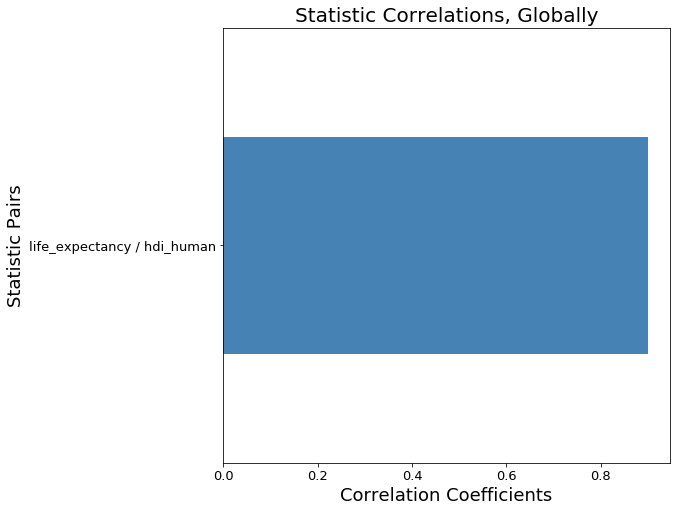

In [42]:
df = dataset_corrs[dataset_corrs['size'] == 'all']
x = df['r']
y = df['this_stat'].astype(str) + ' / ' + df['that_stat'].astype(str)
data = pd.concat([x,y], axis=1).set_index(0).rename_axis('this/that')
ax = data['r'].plot(kind='barh',fontsize=13, color='steelblue',figsize=(8,8));
ax.set_title("Statistic Correlations, Globally", fontsize=20, color='black')
ax.set_xlabel("Correlation Coefficients", fontsize=18, color='black')
ax.set_ylabel("Statistic Pairs", fontsize=18, color='black');
plt.show()

***